# Analyzing NYC High School Data

# Introduction

The SAT (Schoolastic Aptitude Test) is administered during the senior year of high school. Colleges across the country rely on SAT  scores as one of their key admission critera.

A college degree is important to unlocking increased opportunities for social and economic advancement. Because of the SAT's importance in the college admissions process it come under increased scrutiny and concern that it may help perpetuate societal inequality, rather than reducing it, by being subject to various biases.

We will use data published by the New York City Public schools in order to investigate some of these questions and explore some of the demographic factors that may be connected to variations in SAT scores. The inital dataset covers  435 highschools with over 100 pieces of information on school performance, programs and student demographics for each school.

We start by analyzing all the factors and identifying those with the strongest relationship to SAT performance. Then we drill into specific areas of interest.

* Subsidized school lunch in relationship to SAT scores and other factors
* How the results of a survey of students, parents and teachers relate to SAT performance
* The school safety ratings from those surveys and how they relate to SAT scores
* The relationship between students receiving subsidized school lunch and SAT scores
* Racial differences in SAT Scores
* SAT performance by hispanic students
* Gender differences in SAT performance
* The relationship between SAT test scores and participation in AP (Advanced Placement) testing
* Relationships between class size and SAT performance

# Summary

Caveat: This analysis looks at relationships between SAT scores and other factors. These relationships could exist because of coincidence, or because they stem from the same underlying cause, or because one is the cause of the other.  This analysis can't distinguish among them.

**The single strongest relationship to SAT scores is the socioeconomic status of students.** New York City Schools reports the percentage of students receiving free or reduced price school lunch at each high school. If we compare this percentage to average SAT scores at each school, we find that the more students qualifying for subsidized school lunch programs the lower the schools SAT scores.

Other factors:

* Schools with higher proportions of asian and white students tend to have higher average SAT scores, while schools with higher proportions of black and hispanic students tend to have lower average SAT scores. *However, no racial/ethnic component is as strongly related to SAT scores as the percentage of students receiving free or reduced-cost school lunch*.

* Schools with larger proportions of hispanic students generally cater to new immigrants and have a significant % of students who are learning English. They also tend to have more students receiving free or reduced-cost school lunch.

* Schools with high proportions of students learning English tend to have low average SAT scores. The SAT is only administrered in English, so it makes sense that English language learners would be a strong disadvantage.

* The gender makeup of schools does not appear to be closely related to SAT scores.

* There is not an obvious relationship between SAT scores and the number of students taking AP exams.

* By analyzing survey data, I found that student and teacher perceptions of school safety have some relationship to higher SAT scores, as do student perceptions of academic expectations.

* Further investigating the student responses about school safety, I found that:
  * Brooklyn, Queens and the Bronx all have school districts that get the highest safety ratings from students, and *also* have school districts that get lowest safety ratings. 
  * Staten Island's single district is slightly below the overall average.
  * Manhattan's schools are all in the middle of the range, with no schools at either end of the extreme.






# Data Preparation

## Import libraries and configure notebook environment

In [1]:
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy
import pandas as pd
from pandas.plotting import scatter_matrix
import re

%matplotlib inline
%config InlineBackend.figure_format='retina'
#pd.options.display.max_rows = 200
pd.options.display.max_columns = 30

## Read in the data

In [2]:
data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

## Read in the surveys

In [3]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

## Add DBN columns

In [4]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

## Convert columns to numeric

In [5]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

## Condense datasets

In [6]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

## Convert AP scores to numeric

In [7]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

## Convert Graduation data to numeric

In [8]:
data['graduation'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 405 entries, 3 to 2494
Data columns (total 23 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   Demographic                         405 non-null    object
 1   DBN                                 405 non-null    object
 2   School Name                         405 non-null    object
 3   Cohort                              405 non-null    object
 4   Total Cohort                        405 non-null    int64 
 5   Total Grads - n                     405 non-null    object
 6   Total Grads - % of cohort           405 non-null    object
 7   Total Regents - n                   405 non-null    object
 8   Total Regents - % of cohort         405 non-null    object
 9   Total Regents - % of grads          405 non-null    object
 10  Advanced Regents - n                405 non-null    object
 11  Advanced Regents - % of cohort      405 non-null    objec

In [9]:
for col in data['graduation'].columns[5:]:
    data['graduation'][col] = pd.to_numeric(data['graduation'][col].str.strip().str.replace('%',''), errors="coerce")

## Combine the datasets

In [10]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.dropna(axis=1, thresh=len(combined)*.25)
combined = combined.fillna(0)

## Add a school district column for mapping

In [11]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Analysis

## Find correlations

In [12]:
correlations = combined.corr()
#correlations = correlations
print(correlations["sat_score"].sort_values())

frl_percent                    -0.722225
Local - % of grads             -0.494732
Still Enrolled - % of cohort   -0.491914
Local - % of cohort            -0.467951
Dropped Out - % of cohort      -0.458537
                                  ...   
SAT Writing Avg. Score          0.987771
sat_score                       1.000000
schoolyear                           NaN
grade_span_max                       NaN
expgrade_span_max                    NaN
Name: sat_score, Length: 80, dtype: float64


<AxesSubplot:>

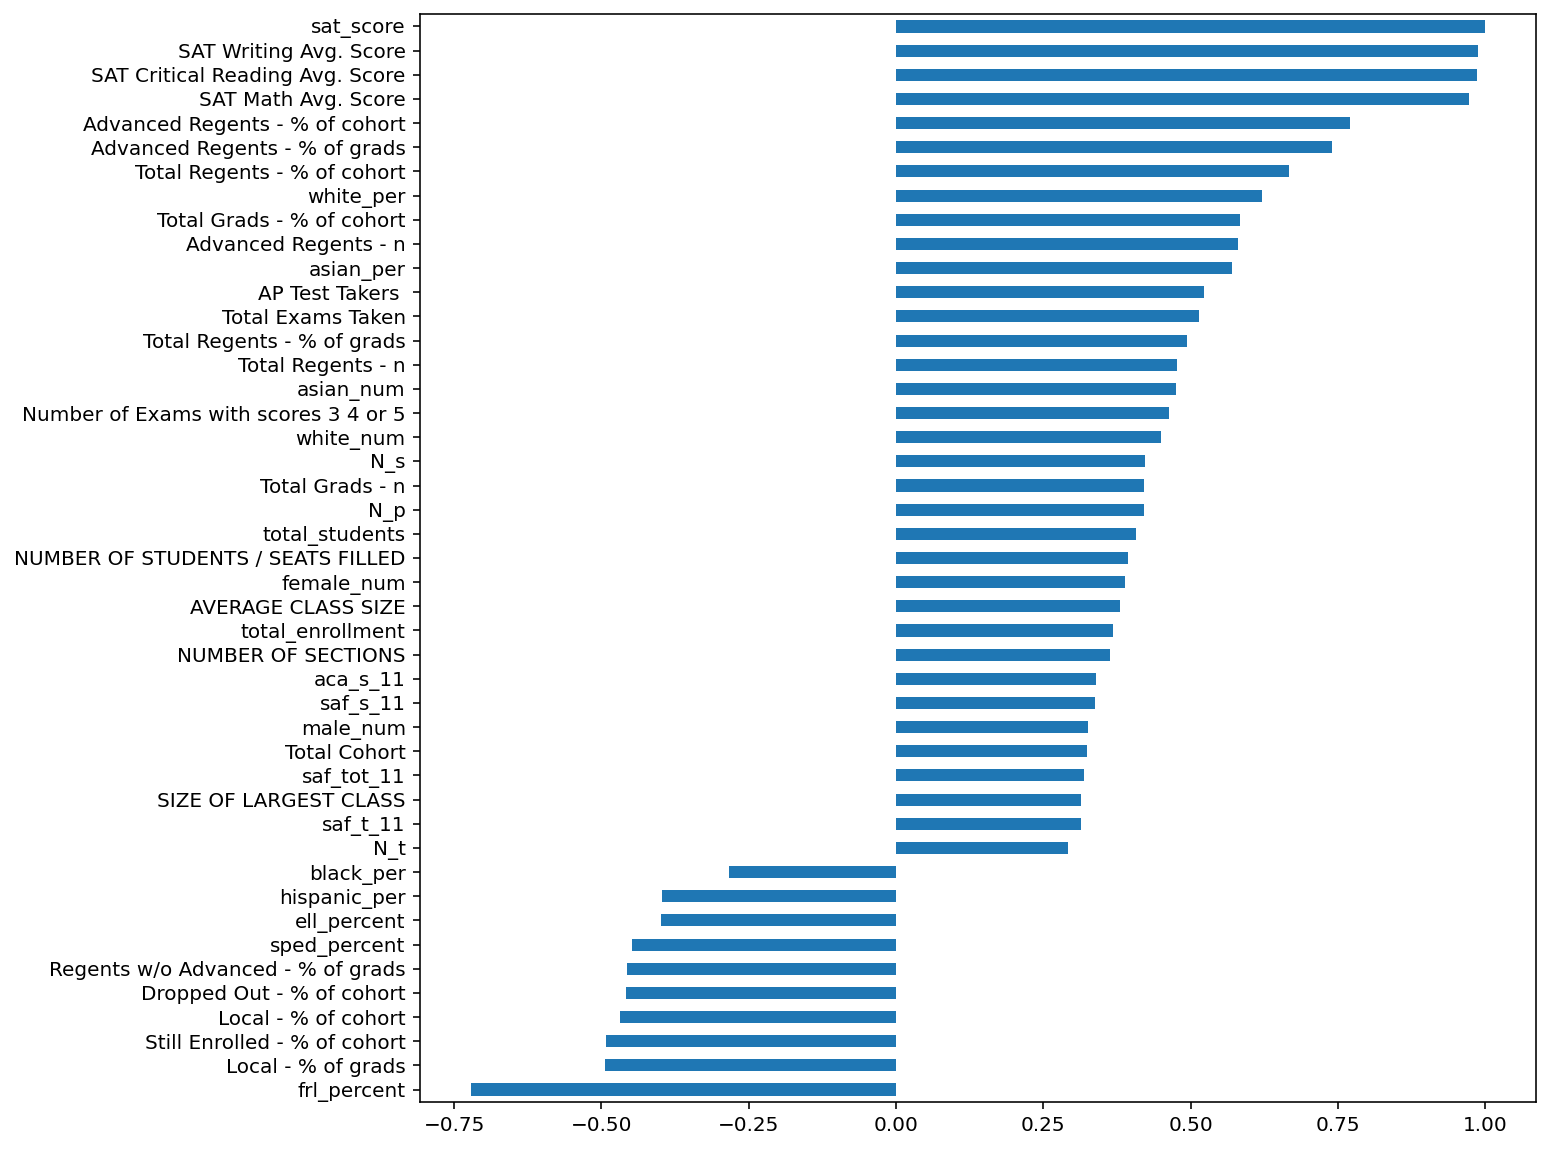

In [13]:
correlations[correlations["sat_score"].abs() > .25]["sat_score"].sort_values().plot.barh(figsize = (10,10))

`frl_percent`, which is the percentage of students who qualify for free or reduced-price school lunch, has a strong negative correlation with `sat_scores`, with an R-value of -0.722225. The only other correlations of this magnitude are positive, and are other metrics of academic performance.

Other demographic characteristics with a negative correlation to SAT scores:

* `black_per`: percentage of black students in student body
* `hispanic_per`: percentage of hispanic students
* `ell_percent`: percentage of students learning english
* `sped_percent`: percentage of students receiving special education

The academic measures that correlate most strongly are, not surprisingly, the SAT subscores (Writing, Math, Critical Reading). Percentages of students receiving advanced "Regents" diplomas also correlates strongly with high SAT scores.




Interestingly class and school size also seem to have a positive correlation with SAT scores.



## Significance of Students Receiving Subsidized School Lunch

We saw above that the percentage of students receiving free or reduced-price lunch (FRL) correlates strongly with lower SAT scores. Below I investigate that relationship, and identify other factors that correlate strongly with the percentage of FRL students.

<AxesSubplot:xlabel='frl_percent', ylabel='sat_score'>

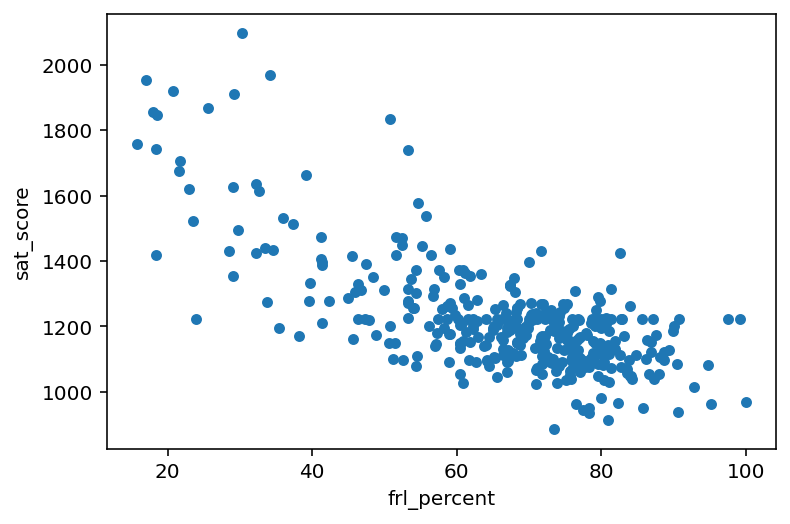

In [14]:
combined.plot.scatter(x='frl_percent', y='sat_score')

Plotting SAT scores against the percentage of students receiving subsidized school lunch makes the relationship between the more obvious, and also underscores the fact that the average NYC public highschool has more than 50% of students receiving subsidized school lunch.

In [15]:
correlations[abs(correlations['frl_percent']) >0.3]['frl_percent'].sort_values()

SAT Critical Reading Avg. Score     -0.728239
SAT Writing Avg. Score              -0.726211
white_per                           -0.722343
sat_score                           -0.722225
SAT Math Avg. Score                 -0.676980
Advanced Regents - % of cohort      -0.532949
Total Regents - % of cohort         -0.523438
white_num                           -0.522679
Advanced Regents - % of grads       -0.514274
Total Grads - % of cohort           -0.470011
Total Regents - n                   -0.417284
Advanced Regents - n                -0.400954
AVERAGE CLASS SIZE                  -0.400651
total_students                      -0.389917
Total Grads - n                     -0.388740
Total Regents - % of grads          -0.384044
asian_per                           -0.383266
female_num                          -0.381732
N_s                                 -0.376787
total_enrollment                    -0.359074
SIZE OF LARGEST CLASS               -0.350282
NUMBER OF STUDENTS / SEATS FILLED 

There are a number of factors with strong negative correlations with `frl_percent`. Most are other academic measures, which we saw earlier have a high positive correlation with SAT scores. Interestingly, the relationship is stronger for the Critical Reading and Writing SAT scores than it is for the Math portion. Other factors with a strong negative correlation include the percentage of white students.

The strongest positive correlation is with the percentage of hispanic students (`hispanic_per`) followed by the percentage of students considered english language learners (`ell_percent`). 

## Plotting Survey Correlations

Our dataset includes responses to a set of survey questions presented to students, teachers and parents. This gives us an opportunity to explore how their perceptions relate to SAT scores.

In [16]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

<AxesSubplot:>

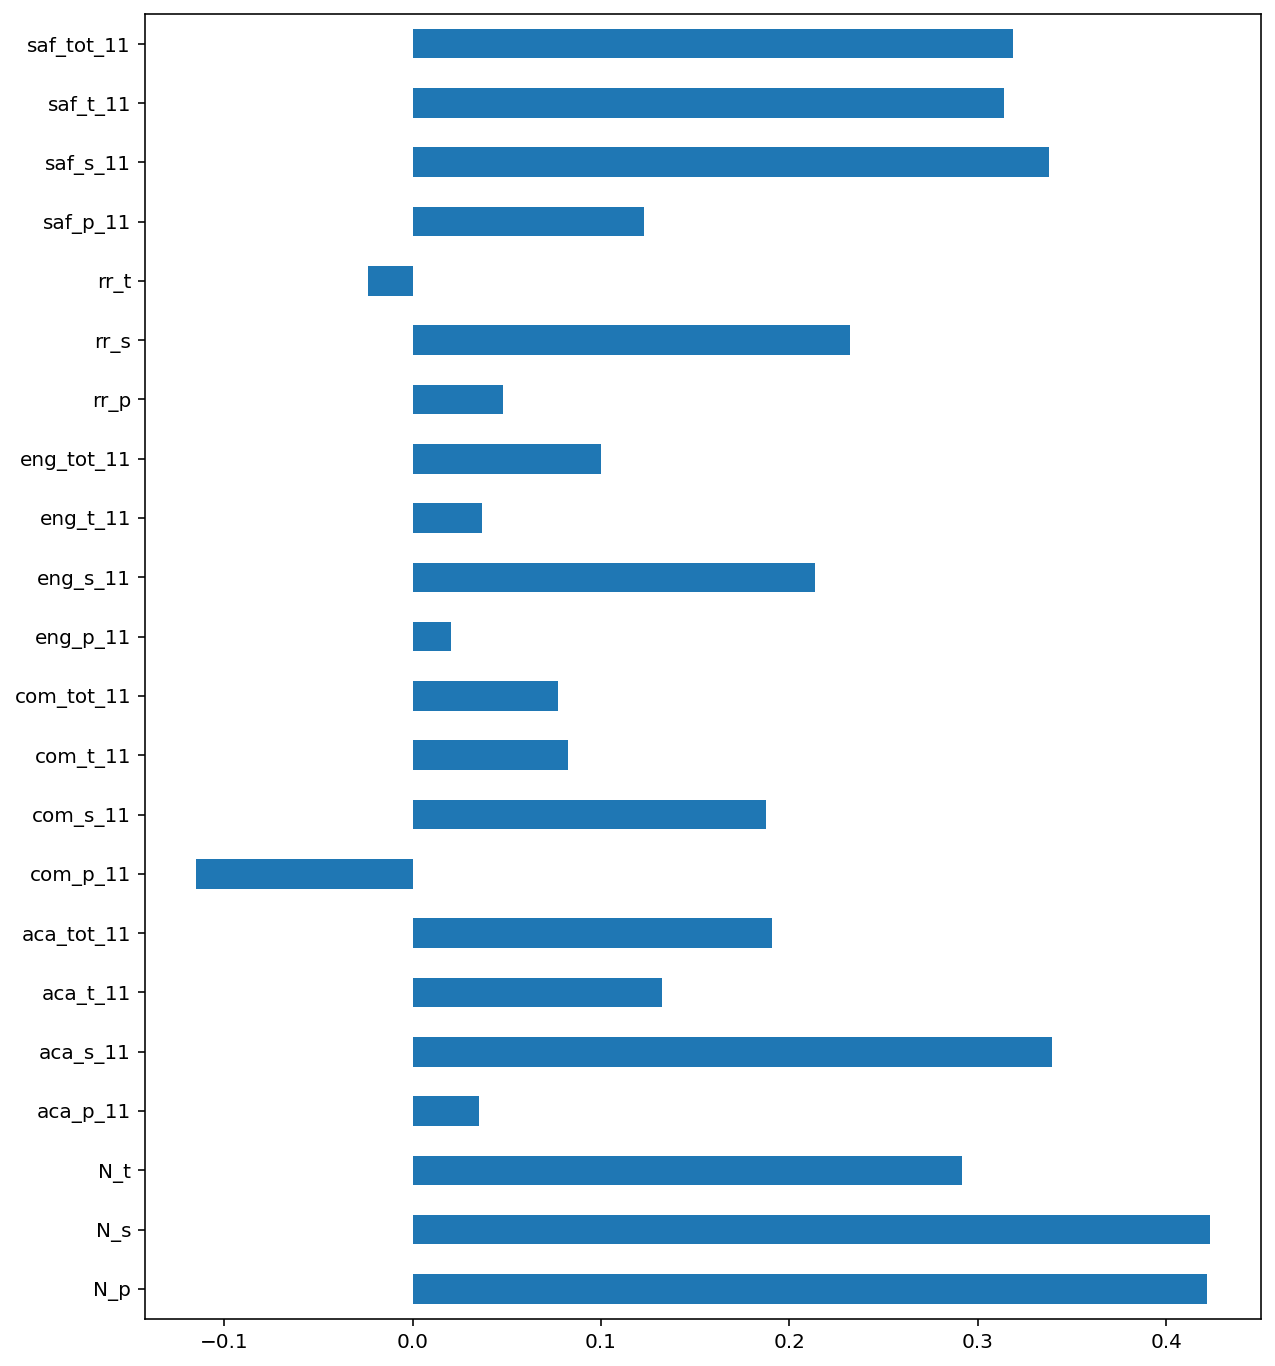

In [17]:
survey_fields.sort()
correlations["sat_score"][survey_fields].plot.barh(figsize=(10,12))

**Key:** 
* The first three letters indicate the question asked: 
  * aca: Academic expections
  * com: Communications
  * eng: Engagement
  * saf: Safety
  * r: Response rate
  * N: Total number of respondants
* The next letters are the different categores of respondants.
  * p: parents
  * t: teachers
  * s: students
  * tot: Total of all the above categories
* The trailing number, where present, indicates the position of the question on the survey.

**Observations:**

* The strongest correlations are for the number of parents and students responding the the survey. This is largely determined by school size, which, we've already noted, has a positive correlation with SAT scores.

* Among the survey questions, parent, student and teacher ratings of school safety show the strongest correlation with SAT scores. 

* Student reports of engagement correlate weakly with higher SAT scores, but much more strongly than teacher or parent perceptions.

* Student reports of academic expectations correlates with higher SAT scores, more so than teacher perceptions, and much more than parental perceptions.

## Exploring Safety Scores

As noted above, student and teacher perceptions of safety have a positive relationship with SAT scores. This seems like an important relationship, and further, safety is also important on its own. I investigate this in more detail below.

<AxesSubplot:xlabel='saf_s_11', ylabel='sat_score'>

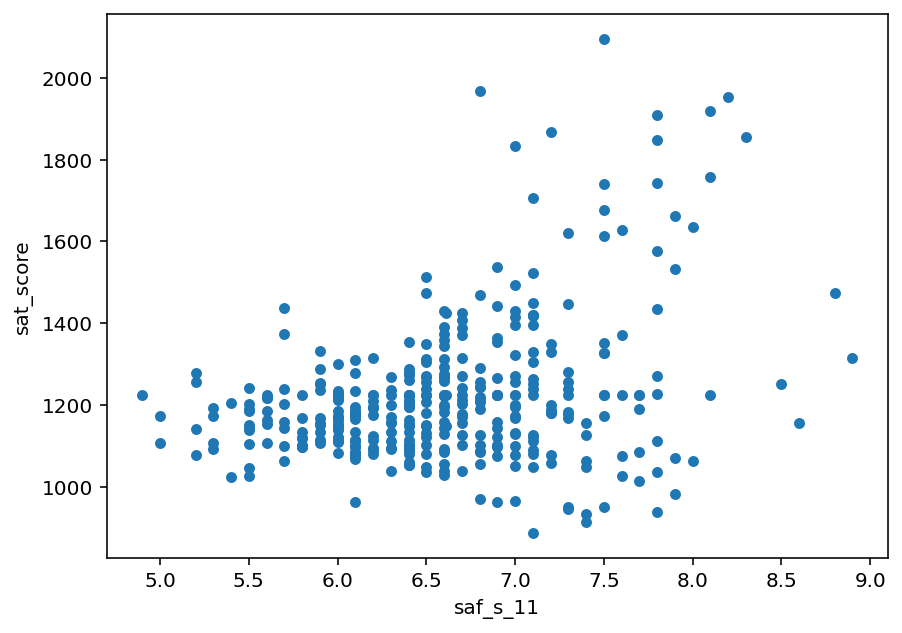

In [18]:
combined.plot.scatter(x='saf_s_11', y='sat_score', figsize=(7,5))

While a correlation analysis identifies a relationship between SAT scores and safety scores, the relationship is only really evident above `saf_s_11` scores of ~6.5.

### Safety Scores by District

In [19]:
district_averages = combined.groupby('school_dist').mean()

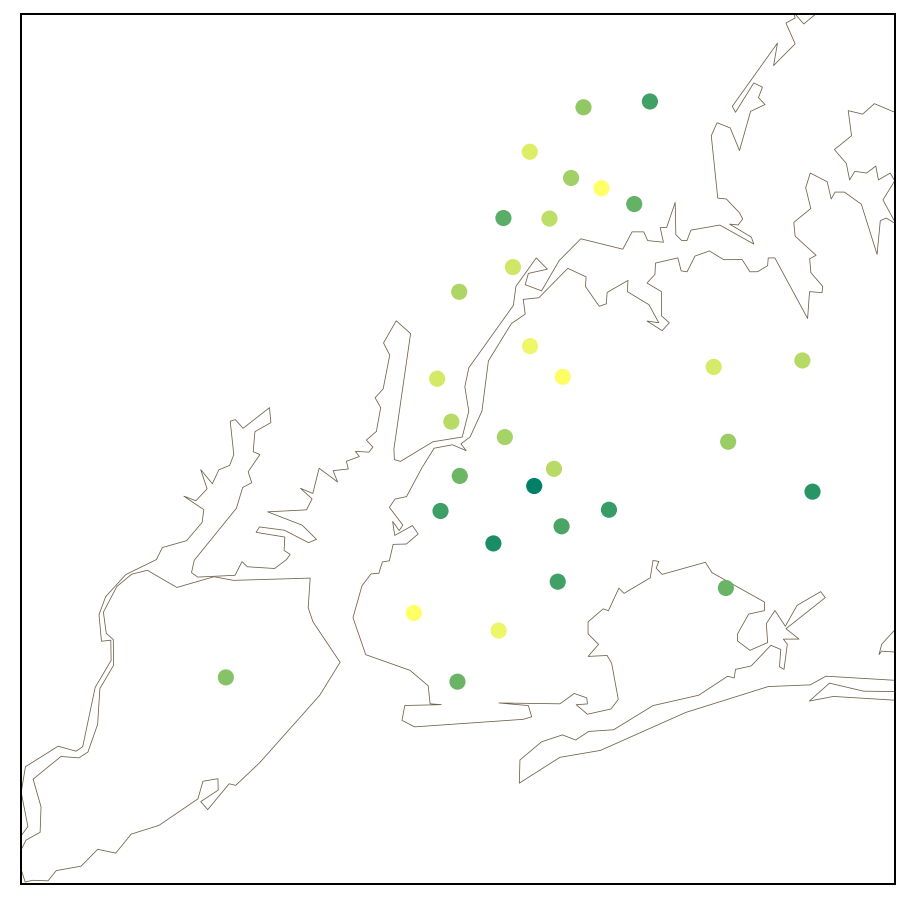

In [20]:
plt.figure(figsize=(8,8))
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='h',
)

m.drawmapboundary()
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

lat = district_averages['lat'].tolist()
lon = district_averages['lon'].tolist()

m.scatter(lon, lat, s=50, zorder=2, latlon=True, c=district_averages['saf_s_11'], cmap='summer')
plt.show()

In [21]:
print("min:", district_averages['saf_s_11'].min())
print("mean:", district_averages['saf_s_11'].mean())
print("max:", district_averages['saf_s_11'].max())
print("stdev:", district_averages['saf_s_11'].std())

min: 5.875
mean: 6.5847557596483375
max: 7.12
stdev: 0.35805290816706803


In [22]:
combined.pivot_table(index=['boro', 'school_dist'], values='saf_s_11', margins='All')

saf_s_11
boro          school_dist          
Bronx         07           6.800000
              08           6.364697
              09           6.655000
              10           6.577273
              11           6.186667
              12           7.116667
Brooklyn      13           6.407692
              14           6.685714
              15           6.177778
              16           5.875000
              17           6.007143
              18           6.190909
              19           6.150000
              20           7.120000
              21           6.390909
              22           7.025000
              23           6.233333
              32           6.766667
Manhattan     01           6.768611
              02           6.910660
              03           6.716667
              04           6.885714
              05           6.314286
              06           6.950000
Queens        24           7.107692
              25           6.912500
              26           6.760000
              27           6.390000
              28           6.627273
              29           6.075000
              30           7.033333
Staten Island 31           6.530000
All                        6.611667

* Across all districts, `saf_s_11` scores, range from a low of 5.87 for district 16 in Brooklyn, to a high of 7.12 for district 20, which is also in Brooklyn.
* Queens and the Bronx also repeat this pattern of having districts near both the bottom and top of the range.
* Staten Island's only district's `saf_s_11` score is a bit below the citywide mean. 
* Manhattan's districts have a narrower distribution with scores falling within approximately one standard deviation of the citywide mean.

## Differences in Survey Responses Between Teachers, Students and Parents

The survey scores show some differences between the different groups (parents, students, teachers) taking the survey. Here I investigate those differences.

[Text(0, 0, 'Safety'),
 Text(0, 1, 'Engagement'),
 Text(0, 2, 'Communication'),
 Text(0, 3, 'Academic Expectations')]

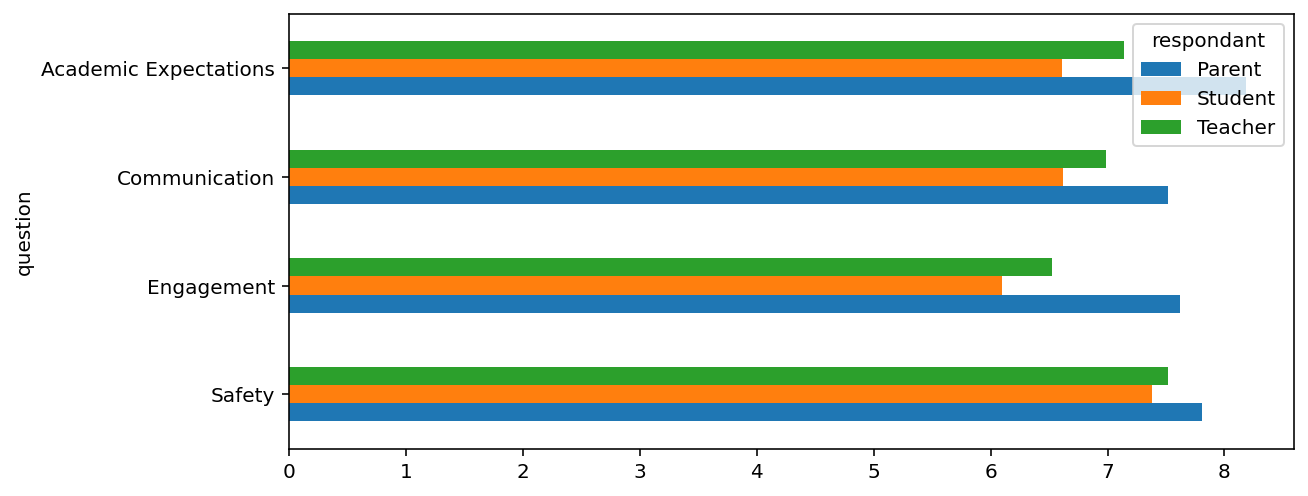

In [23]:
survey_data = combined[['DBN'] + survey_fields]
survey_data = survey_data.melt(id_vars='DBN')
#There has to be a better way?
survey_data[['question','respondant']] = pd.DataFrame(survey_data['variable'].str.split("_").to_list()).iloc[:,0:2]
survey_data = survey_data.drop('variable', axis=1)
survey_data = survey_data[survey_data['question'] != 'N']
survey_data = survey_data[survey_data['question'] != 'rr']
survey_data = survey_data[survey_data['respondant'] != 'tot']
survey_data['respondant'] = survey_data['respondant'].map({"p": "Parent", "s": "Student", "t": "Teacher"})
survey_data = survey_data.reset_index(drop=True)
#Finally!
ax = survey_data.pivot_table(index='question', columns='respondant', values='value').plot.barh(figsize=(9,4))
ax.set_yticklabels(["Safety", "Engagement", "Communication", "Academic Expectations"])

We can see, in the chart above, that parents, students, and teachers have similar perceptions of safety, engagement, academic expections and communications. Students rate things slighly lower than teachers do, while parents rate them slightly higher. 

## Racial Differences in SAT Scores

<AxesSubplot:>

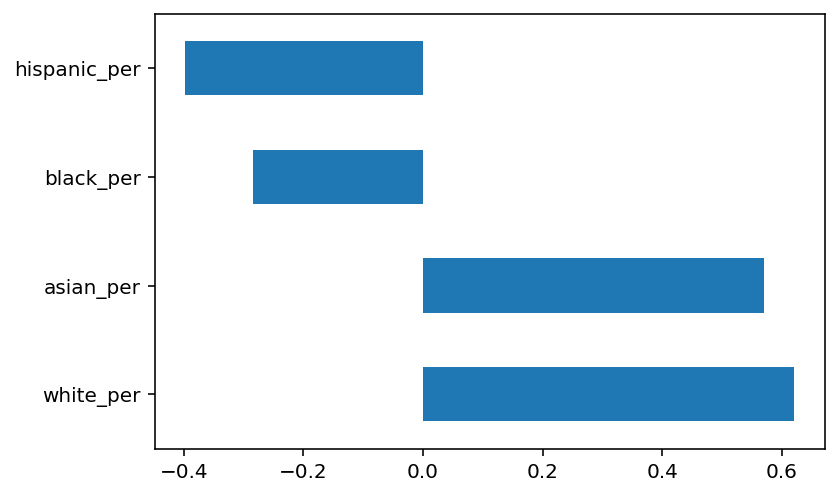

In [24]:
race_columns = ['white_per', 'asian_per', 'black_per', 'hispanic_per']

correlations['sat_score'][race_columns].plot.barh()

There is a inverse relationship between percentage of Black or Hispanic students and a school's average SAT scores. There is a stronger positive relationship between percentage of White or Asian students and a school's SAT scores.

*Keep in mind that we earlier found that a proxy for socioeconomic status, `frl_percent` (the percentage of students receiving subsidized school lunch) had a strong negative correlation with SAT scores.*

<AxesSubplot:>

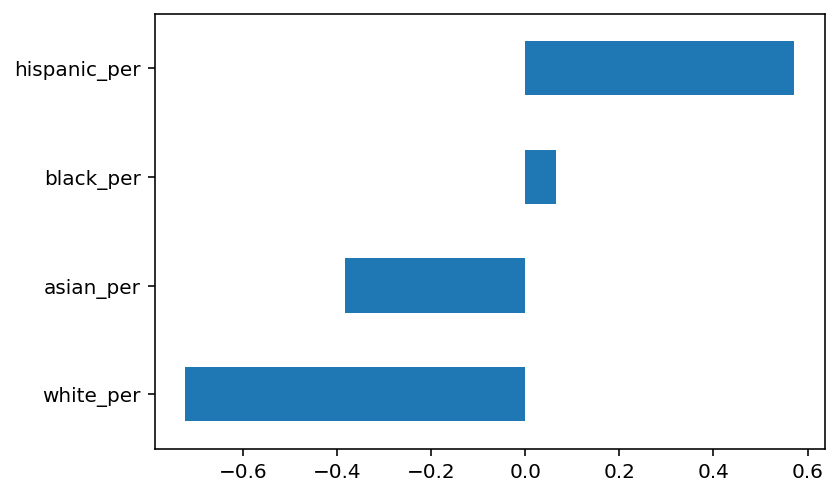

In [25]:
correlations['frl_percent'][race_columns].plot.barh()

Above we see how `frl_percent`, the percentage of students receiving subsidized lunch, correlate with racial makup of schools. Racial diferences in socioeconomic status could help explain racial disparities in SAT scores. This could be the subject of a separate analysis.

## SAT Performance by Hispanic Students

Let's take a closer look at the percentage of hispanic students and school's average SAT scores.

<AxesSubplot:xlabel='hispanic_per', ylabel='sat_score'>

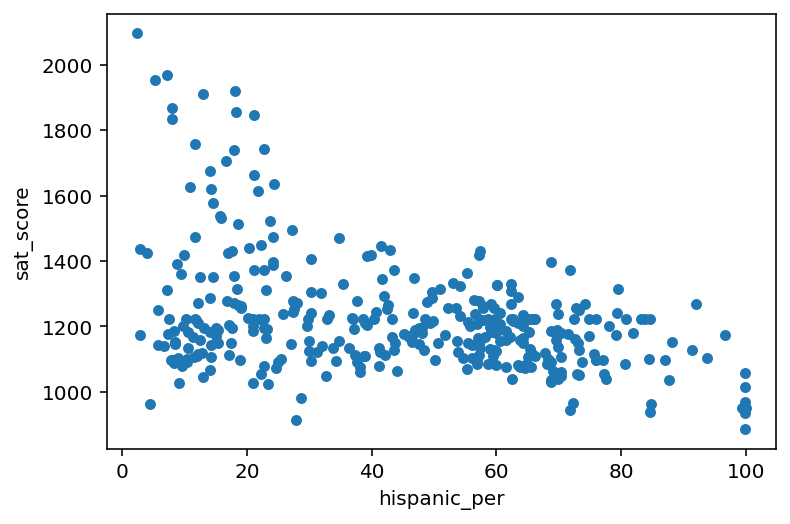

In [26]:
combined.plot.scatter(x='hispanic_per', y='sat_score')

We can see that the schools with highest average SAT scores have low percentages of hispanic students. In addition, the schools with nearly 100% hispanic students have some of the lowest average SAT scores.

However, schools with the lowest SAT scores have a wide range of percentages of hispanic students. Moreover, schools with average SAT scores also have a wide range of percentages of hispanic students.

Let's look at schools with >95% hispanic students and see what we can learn about them.

In [27]:
high_hispanic = combined[combined['hispanic_per'] >95]
high_hispanic.T

,44,82,89,125,141,176,253,286
DBN,02M542,06M348,06M552,09X365,10X342,12X388,19K583,24Q296
SCHOOL NAME,MANHATTAN BRIDGES HIGH SCHOOL,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,ACADEMY FOR LANGUAGE AND TECHNOLOGY,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,MULTICULTURAL HIGH SCHOOL,PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Num of SAT Test Takers,66,70,56,54,49,30,29,55
SAT Critical Reading Avg. Score,336,380,339,315,300,321,279,317
SAT Math Avg. Score,378,395,349,339,333,351,322,323
...,...,...,...,...,...,...,...,...
priority04,0,Then to District 6 students or residents,Then to New York City residents who have lived...,0,0,0,0,0
Location 1,"525 West 50Th Street\nNew York, NY 10019\n(40....","511 West 182Nd Street\nNew York, NY 10033\n(40...","501 West 165Th\nNew York, NY 10032\n(40.838032...","1700 Macombs Road\nBronx, NY 10453\n(40.849102...","2780 Reservoir Avenue\nBronx, NY 10468\n(40.87...","1300 Boynton Avenue\nBronx, NY 10472\n(40.8313...","999 Jamaica Avenue\nBrooklyn, NY 11208\n(40.69...","45-10 94Th Street\nElmhurst, NY 11373\n(40.743..."
lat,40.765,40.8489,40.838,40.8491,40.8704,40.8314,40.6911,40.7433
lon,-73.9925,-73.9308,-73.9384,-73.9161,-73.8982,-73.8788,-73.8684,-73.8706


**Select details:**
* MANHATTAN BRIDGES HIGH SCHOOL: Caters to recently arrived students from spanish-speaking countries. 46% english language learners, but all have spanish as native language. 100% minority. 83% low-SES. High college readyness and performance on state-mandated standardized tests. Good discipline/order.
* WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL: 81% low-SES. 91%hispanic. 16% english language learners. Lots of experiential learning. 90% graduate in 4y. Average college prep performance.
* GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...:  Focus on spanish speaking students new to the country (less than 2y) with at least 8y education in their native countries. 78% english language learners. Entering students are often poorly prepared academically -- Low 4y graduation rate. 80% 6-year graduation rate. 99% low SES. Below average college readyness.
* ACADEMY FOR LANGUAGE AND TECHNOLOGY: Focus on new immigrants. Most students graduate on time. 100% latino. 2/3rds english language learners. Orderly and Safe. 100% low-SES. Good college readyness.
* INTERNATIONAL SCHOOL FOR LIBERAL ARTS 100% hispanic. 71% learning english (admissions focused on those who use spanish as primary language at home). 75% graduate on time. Average safety. 98% low SES. Many students enter with poor academic preparation but overall, students make good progress.
* PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE: Focus on new spanish-speaking immigrants. Above average safety and discipline. 84% graduate in 4 years. 99% low SES. 88% english language learners. 30% interrupted education. 40% unaccompanied minors.
* MULTICULTURAL HIGH SCHOOL: Mix of In US less than 3y and longer residing bi-lingual students. 98% hispanic. 88% english language learners. 93% low-SES. Average order but above average bullying. Many students are older than average and have to help support their families. Problematic college prep.	
* PAN AMERICAN INTERNATIONAL HIGH SCHOOL: All students have been in US less than 4y and speak spanish. Most teachers speak english-only. Good safety. 85% graduate in 4y. Problematic college prep. 99% hispanic. 84% low-SES. 84% english language learners.

More than 80% at all these schools (>90% in most) qualify for free or reduced-price lunch, indicating that most students are of low socio-economic status. Recall that we earlier found that the percentage of students receiving free or reduced price lunch had a strong negative correlation with SAT scores.

Most have ~50% or more students who are english language learners.

Let's contrast this with schools with low percentages of hispanic students and high SAT scores.

In [28]:
low_hispanic = combined[(combined['hispanic_per'] <10) & (combined['sat_score']>1800)]
low_hispanic.T

,37,151,187,327,356
DBN,02M475,10X445,13K430,28Q687,31R605
SCHOOL NAME,STUYVESANT HIGH SCHOOL,BRONX HIGH SCHOOL OF SCIENCE,BROOKLYN TECHNICAL HIGH SCHOOL,QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...,STATEN ISLAND TECHNICAL HIGH SCHOOL
Num of SAT Test Takers,832,731,1277,121,227
SAT Critical Reading Avg. Score,679,632,587,612,635
SAT Math Avg. Score,735,688,659,660,682
...,...,...,...,...,...
priority04,0,0,0,0,0
Location 1,"345 Chambers Street\nNew York, NY 10282\n(40.7...","75 West 205 Street\nBronx, NY 10468\n(40.87705...","29 Ft Greene Place\nBrooklyn, NY 11217\n(40.68...","94-50 159 Street\nJamaica, NY 11433\n(40.70099...","485 Clawson Street\nStaten Island, NY 10306\n(..."
lat,40.7177,40.8771,40.6881,40.701,40.5679
lon,-74.014,-73.8898,-73.9767,-73.7982,-74.1154


The schools with the highest SAT scores and lowest proportions of hispanic students are majority asian, with one exception. They all have ~0% english language learners, and <=50% low-SES (using subsidized school lunch as the proxy). All have selective admissions based on test scores.

Most or all have a focus on Science, Technology, Engineering and Math (STEM).

In [29]:
combined[(combined['hispanic_per'] >20) & (combined['sat_score']>1800)].T

,79
DBN,05M692
SCHOOL NAME,"HIGH SCHOOL FOR MATHEMATICS, SCIENCE AND ENGIN..."
Num of SAT Test Takers,101
SAT Critical Reading Avg. Score,605
SAT Math Avg. Score,654
...,...
priority04,0
Location 1,"240 Convent Ave\nNew York, NY 10031\n(40.82112..."
lat,40.8211
lon,-73.9488


There is only one school with high average SAT scores and more than than 20% hispanic students, the High School for Mathematics, Science, and Engineering (HSMSE). It is a small (~100 students per cohort) STEM-focused school located in Manhattan and draws from students from all five bouroghs. Despite having a significant hispanic population, the school has 0% english language learners. This sets it apart from the predominantly hispanic schools we looked at earlier.

HSMSE, like other selective, specialized high schools in the NYC Schools requires a foreign language for graduation.  It is somewhat unusual though in that it only offers two languages. All students must take German, unless they can demonstrate proficiency in Spanish, in which case they can elect to study advanced Spanish, instead. This may not explain the relatively high percentage of hispanic students though as all the other competitive high schools, save one, offer Spanish among their language options. Two, Brooklyn Latin and the High School of American Studies, require Spanish of all students. Queens HS of Sciences also offers Spanish in addition to only one other language (Mandarin).

## SAT Scores and English Language Learners.

We saw earlier that the more english language learners a school has, the lower the average SAT scores tend to be. Let's look at that in a little more detail, along side some of the other variables we've been interested in.

<AxesSubplot:xlabel='ell_percent', ylabel='sat_score'>

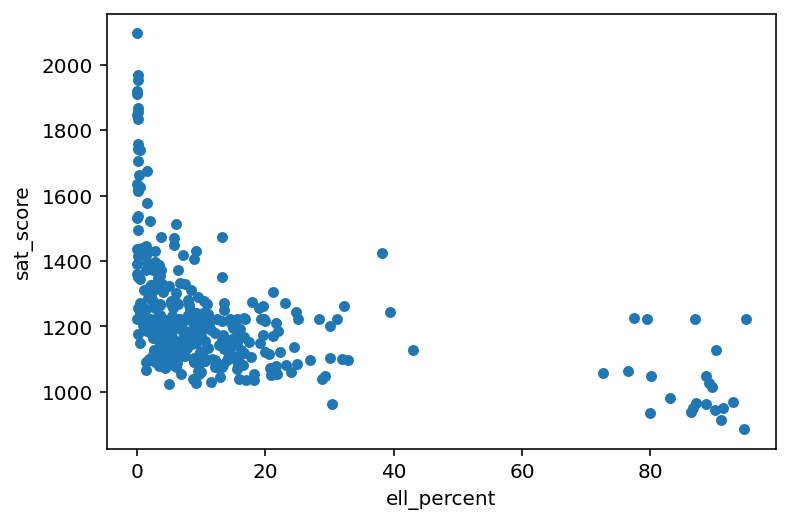

In [30]:
combined.plot.scatter(x='ell_percent', y='sat_score')

The relationship between `sat_scores` and `ell_percent` is most clear at the extremes. Top schools (investigated earlier) have few if any english language learners while schools that predominantly have english language learners have below school average SAT scores, and some have the lowest school average SAT scores in the system. Between the two extremes the relationship is still visible.

Interestingly schools tend to either have fewer than 30% of students learning english, or more than 70%.

In [31]:
combined[combined['sat_score'] > 1700][['SCHOOL NAME', 'sat_score', 'hispanic_per', 'frl_percent', 'ell_percent']]

,SCHOOL NAME,sat_score,hispanic_per,frl_percent,ell_percent
5,BARD HIGH SCHOOL EARLY COLLEGE,1856.0,18.2,18.0,0.2
26,ELEANOR ROOSEVELT HIGH SCHOOL,1758.0,11.6,15.8,0.2
37,STUYVESANT HIGH SCHOOL,2096.0,2.4,30.3,0.0
60,BEACON HIGH SCHOOL,1744.0,22.8,18.4,0.2
61,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,1707.0,16.6,21.7,0.2
79,"HIGH SCHOOL FOR MATHEMATICS, SCIENCE AND ENGIN...",1847.0,21.2,18.5,0.0
151,BRONX HIGH SCHOOL OF SCIENCE,1969.0,7.2,34.2,0.1
155,HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEGE,1920.0,18.0,20.8,0.0
187,BROOKLYN TECHNICAL HIGH SCHOOL,1833.0,7.9,50.7,0.1
198,"BROOKLYN LATIN SCHOOL, THE",1740.0,17.9,53.3,0.4


The table above shows schools with the highest high average SAT scores. Their hispanic student populations range from 2.4% to 22.8%, and the proportion of students receiving subsidized lunch (a proxy for low socioeconomic status) range from 15.8% to 53.3%. However, none have more 0.5% of their student body learning english.

## Gender differences in SAT Performance

<AxesSubplot:>

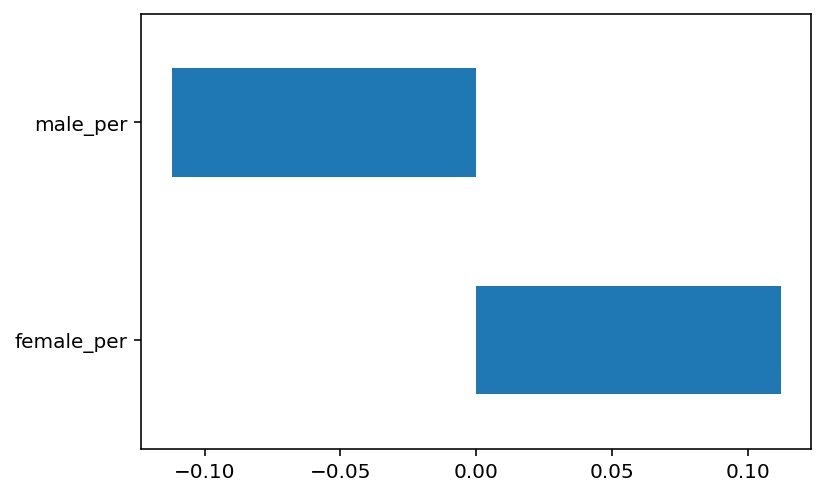

In [32]:
correlations["sat_score"][['female_per', 'male_per']].plot.barh()

These corrlation values are very low; there is no correlation between the gender-balance in schools and their average SAT scores.

Nevertheless, we can take this opportunity to look at the few high schools with predominantly female (>60%) student bodies and high (>1700) school average SAT scores.

In [33]:
combined[(combined['female_per'] >60) & (combined['sat_score']>1700)].T

,5,26,60,61,302
DBN,01M696,02M416,03M479,03M485,25Q525
SCHOOL NAME,BARD HIGH SCHOOL EARLY COLLEGE,ELEANOR ROOSEVELT HIGH SCHOOL,BEACON HIGH SCHOOL,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,TOWNSEND HARRIS HIGH SCHOOL
Num of SAT Test Takers,130,127,261,531,278
SAT Critical Reading Avg. Score,624,572,577,566,621
SAT Math Avg. Score,604,594,575,564,651
...,...,...,...,...,...
priority04,0,0,0,Students must be residents of New York City at...,0
Location 1,"525 East Houston Street\nNew York, NY 10002\n(...","411 East 76 Street\nNew York, NY 10021\n(40.77...","227-243 West 61St Street\nNew York, NY 10023\n...","100 Amsterdam Avenue\nNew York, NY 10023\n(40....","149-11 Melbourne Avenue\nFlushing, NY 11367\n(..."
lat,40.719,40.7701,40.7722,40.7737,40.7344
lon,-73.9761,-73.9534,-73.9878,-73.9853,-73.8214


All of the above schools have selective admissions. Unlike the other selective schools with high SAT scores investigated earlier, these schools don't seem to have a scientific/technical focus. They are instead either a more balanced liberal arts cirriculum, arts or humanities. All have less than ~30% receiving free or reduced cost school lunch and ~0% English language learners.

There is only one school where the ratios are reversed.

In [34]:
combined[(combined['male_per'] >60) & (combined['sat_score']>1700)].T

,79
DBN,05M692
SCHOOL NAME,"HIGH SCHOOL FOR MATHEMATICS, SCIENCE AND ENGIN..."
Num of SAT Test Takers,101
SAT Critical Reading Avg. Score,605
SAT Math Avg. Score,654
...,...
priority04,0
Location 1,"240 Convent Ave\nNew York, NY 10031\n(40.82112..."
lat,40.8211
lon,-73.9488


In [35]:
combined[((combined['male_per'] > 50)) & (combined['sat_score']>1700)][['SCHOOL NAME', 'sat_score','male_per']].reset_index(drop=True)

,SCHOOL NAME,sat_score,male_per
0,STUYVESANT HIGH SCHOOL,2096.0,59.3
1,"HIGH SCHOOL FOR MATHEMATICS, SCIENCE AND ENGIN...",1847.0,65.8
2,BRONX HIGH SCHOOL OF SCIENCE,1969.0,57.8
3,HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEGE,1920.0,53.8
4,BROOKLYN TECHNICAL HIGH SCHOOL,1833.0,58.3
5,"BROOKLYN LATIN SCHOOL, THE",1740.0,54.9
6,QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...,1868.0,56.5
7,STATEN ISLAND TECHNICAL HIGH SCHOOL,1953.0,57.0


There are, however eight high-scoring schools with >50% male student bodies. All, save one, are STEM schools. They make up the bulk of NYC's nine specialized high schools, with admissions determined by scores on a standardized aptitude test.

## Relationship between AP Tests and SAT performance

In [36]:
combined['ap_per'] = 100*combined['AP Test Takers '] / combined['total_enrollment']

In [37]:
combined[['ap_per', 'sat_score']].corr()

,ap_per,sat_score
ap_per,1.000000,0.057171
sat_score,0.057171,1.000000


<AxesSubplot:xlabel='ap_per', ylabel='sat_score'>

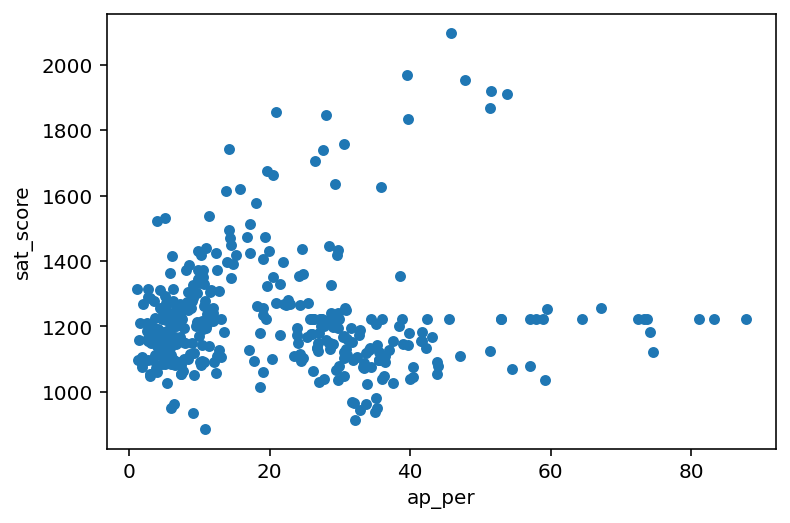

In [38]:
combined.plot.scatter(x='ap_per', y='sat_score')

There isn't a correlation between the percentage of students taking AP exams and SAT test scores. This is unexpected since both seem to go hand-in-hand as part of college prep.

## Relationship betwee Class size and SAT Perfomance

In [39]:
correlations["sat_score"]['AVERAGE CLASS SIZE']

0.3810143308095523

<AxesSubplot:xlabel='AVERAGE CLASS SIZE', ylabel='sat_score'>

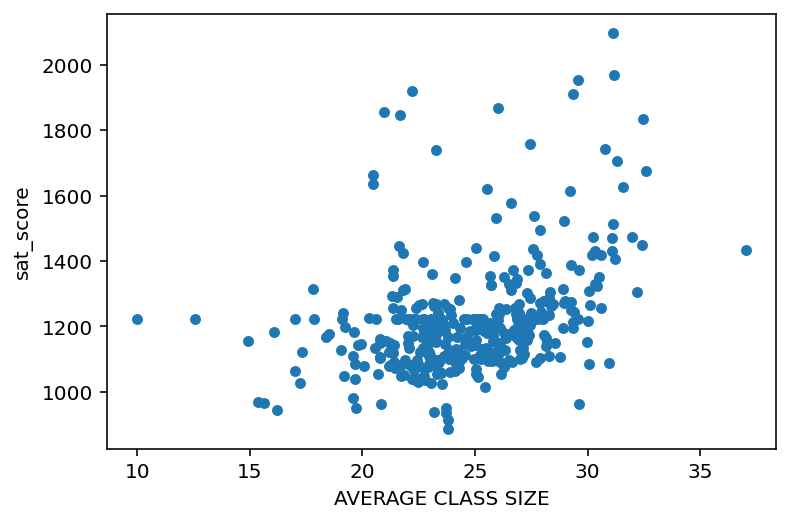

In [40]:
combined.plot.scatter(x='AVERAGE CLASS SIZE', y='sat_score')

There is a relationship between a school's average class size and it's average SAT score.

It's not clear why this would be the case. One hypothesis is that on average the most capable students need less attention from teachers, and so schools assign more of them to a classroom.

# Conclusion

This analysis investigated factors that relate to average SAT performance at individual schools. The presence of these relationship should not be taken to imply a causal link. These relationships could exist because of coincidence, or because they stem from the same underlying cause, or because one is the cause of the other.  This analysis can't distinguish among those possibilities.

We found:
* There isn't clear evidence of gender bias in the SAT.
* There is evidence that race and associated factors do relate to SAT scores. However, this relationship also seems to involve the relationship between race and low socioeconomic status. 
* SAT scores of hispanic students are also likely influenced by a high percentage immigrant English language learners, many of whom didn't receive adequate schooling in their home countries. This intersects with the fact that the SAT is only given in English.

# Appendix

The source of the data used in this analysis is [NYC's data portal](https://data.cityofnewyork.us). The specific source datasets follow:

* [2012 SAT ResultsEducation](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4)
* [2010 - 2011 School Attendance and Enrollment Statistics by District](https://data.cityofnewyork.us/Education/2010-2011-School-Attendance-and-Enrollment-Statist/7z8d-msnt)
* [2010-2011 Class Size - School-level detail](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3)
* [2010 AP (College Board) School Level Results](https://data.cityofnewyork.us/Education/2010-AP-College-Board-School-Level-Results/itfs-ms3e)
* [2005-2010 Graduation Outcomes - School Level](https://data.cityofnewyork.us/Education/2005-2010-Graduation-Outcomes-School-Level/vh2h-md7a)
* [2006 - 2012 School Demographics and Accountability Snapshot](https://data.cityofnewyork.us/Education/2006-2012-School-Demographics-and-Accountability-S/ihfw-zy9j)
* [2011 NYC School Survey](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8)
* [2014 - 2015 DOE High School Directory](https://data.cityofnewyork.us/Education/2014-2015-DOE-High-School-Directory/n3p6-zve2)
